

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

Решение от мая 2021 года

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установим Pillow

In [1]:
# Установим Pillow и проверим его версию, нужна версия 5.3
import PIL
PIL.__version__

'7.1.2'

In [ ]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

### Установка зависимостей

In [4]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


Загрузим данные с гугл диска

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
# Разархивируем файл

!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [1]:
# Проверим загрузились ли данные
!ls train

simpsons_dataset


In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
import time

from torch.optim import lr_scheduler
from tqdm.autonotebook import tqdm, trange
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

# train_on_gpu = torch.cuda.is_available() заменил на выбор

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not DEVICE:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# В случае если GPU работает, то посмотрим ее возможности
!nvidia-smi
import torch
torch.cuda.is_available()

Sat May 15 10:39:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

ПОСТАНОВКА ЗАДАЧИ: В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# Игнорирование предупреждений sklearn
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
# разные режимы датасета (список режимов) 
DATA_MODES = ['train', 'val', 'test']

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
                # Добавил еще несколько преобразователей картинок
                transforms.RandomResizedCrop(224),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((244, 244))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
# Определим данные
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

### Продолжим подготовку данных (картинок)

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
train_dataset = SimpsonsDataset(train_files, mode='train')
dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


Давайте посмотрим на наших героев внутри датасета.

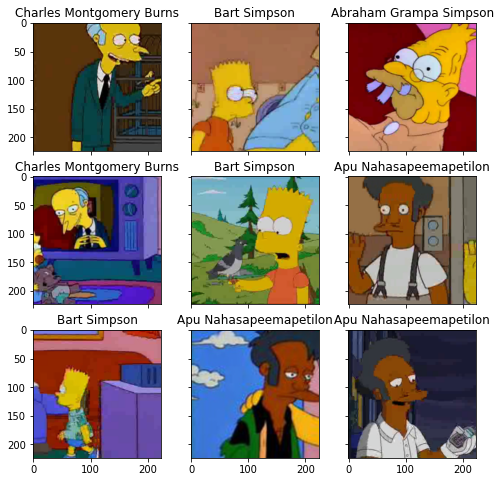

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети


In [10]:
def fit_epoch(model, train_loader, criterion, opt):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        opt.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

Определим функцию, для получения предсказания модели.

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
# Количество классов
n_classes = len(np.unique(train_val_labels))
print(n_classes)

42


### EfficientNet B2-B7

In [24]:
!pip install efficientnet_pytorch

In [ ]:
import ***
model_B7 = ***.to(DEVICE)

In [ ]:
import ***
model_B6 = ***.to('cuda')

In [29]:
history = train(new_train_dataset, val_dataset, model=model_B6, epochs=5, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.3569707104919153


epoch:  20%|██        | 1/5 [04:05<16:22, 245.64s/it]


Epoch 001 train_loss: 1.3570     val_loss 0.3149 train_acc 0.6745 val_acc 0.9201
loss 0.906115626794906


epoch:  40%|████      | 2/5 [08:09<12:14, 244.98s/it]


Epoch 002 train_loss: 0.9061     val_loss 0.2985 train_acc 0.7639 val_acc 0.9261
loss 0.673908512911242


epoch:  60%|██████    | 3/5 [12:11<08:08, 244.36s/it]


Epoch 003 train_loss: 0.6739     val_loss 0.2056 train_acc 0.8221 val_acc 0.9526
loss 0.5124501172979049


epoch:  80%|████████  | 4/5 [16:14<04:03, 243.90s/it]


Epoch 004 train_loss: 0.5125     val_loss 0.1365 train_acc 0.8642 val_acc 0.9671
loss 0.4646853122654029


epoch: 100%|██████████| 5/5 [20:18<00:00, 243.66s/it]


Epoch 005 train_loss: 0.4647     val_loss 0.1380 train_acc 0.8765 val_acc 0.9654


In [ ]:
import ***
model_B7 = ***.to('cuda')

In [16]:
# обучаем
history = train(new_train_dataset, val_dataset, model=model_B7, epochs=25, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 1.329810521538422


epoch:   4%|▍         | 1/25 [04:59<1:59:45, 299.38s/it]


Epoch 001 train_loss: 1.3298     val_loss 0.3317 train_acc 0.6833 val_acc 0.9140
loss 0.9600237036852062


epoch:   8%|▊         | 2/25 [09:54<1:54:15, 298.05s/it]


Epoch 002 train_loss: 0.9600     val_loss 0.2208 train_acc 0.7509 val_acc 0.9459
loss 0.6957275255998587


epoch:  12%|█▏        | 3/25 [14:49<1:48:57, 297.18s/it]


Epoch 003 train_loss: 0.6957     val_loss 0.2142 train_acc 0.8163 val_acc 0.9461
loss 0.5109541762294978


epoch:  16%|█▌        | 4/25 [19:44<1:43:45, 296.46s/it]


Epoch 004 train_loss: 0.5110     val_loss 0.1149 train_acc 0.8674 val_acc 0.9723
loss 0.46496552864839846


epoch:  20%|██        | 5/25 [24:38<1:38:36, 295.83s/it]


Epoch 005 train_loss: 0.4650     val_loss 0.1112 train_acc 0.8765 val_acc 0.9757
loss 0.4328012318909609


epoch:  24%|██▍       | 6/25 [29:32<1:33:31, 295.33s/it]


Epoch 006 train_loss: 0.4328     val_loss 0.1119 train_acc 0.8857 val_acc 0.9752
loss 0.3748016877829164


epoch:  28%|██▊       | 7/25 [34:27<1:28:30, 295.05s/it]


Epoch 007 train_loss: 0.3748     val_loss 0.0830 train_acc 0.9011 val_acc 0.9797
loss 0.3566259059337301


epoch:  32%|███▏      | 8/25 [39:21<1:23:32, 294.88s/it]


Epoch 008 train_loss: 0.3566     val_loss 0.0815 train_acc 0.9018 val_acc 0.9811
loss 0.33989346897542105


epoch:  36%|███▌      | 9/25 [44:16<1:18:39, 294.95s/it]


Epoch 009 train_loss: 0.3399     val_loss 0.0813 train_acc 0.9083 val_acc 0.9792
loss 0.3047485403070509


epoch:  40%|████      | 10/25 [49:11<1:13:43, 294.92s/it]


Epoch 010 train_loss: 0.3047     val_loss 0.0731 train_acc 0.9175 val_acc 0.9834
loss 0.2852473921882009


epoch:  44%|████▍     | 11/25 [54:06<1:08:49, 294.96s/it]


Epoch 011 train_loss: 0.2852     val_loss 0.0722 train_acc 0.9225 val_acc 0.9840
loss 0.2823677054679969


epoch:  48%|████▊     | 12/25 [59:01<1:03:55, 295.03s/it]


Epoch 012 train_loss: 0.2824     val_loss 0.0720 train_acc 0.9228 val_acc 0.9838
loss 0.2661040120847693


epoch:  52%|█████▏    | 13/25 [1:03:56<58:57, 294.78s/it]


Epoch 013 train_loss: 0.2661     val_loss 0.0644 train_acc 0.9281 val_acc 0.9855
loss 0.25491972315960576


epoch:  56%|█████▌    | 14/25 [1:08:50<54:01, 294.65s/it]


Epoch 014 train_loss: 0.2549     val_loss 0.0671 train_acc 0.9313 val_acc 0.9855
loss 0.2454501931467646


epoch:  60%|██████    | 15/25 [1:13:44<49:03, 294.39s/it]


Epoch 015 train_loss: 0.2455     val_loss 0.0673 train_acc 0.9328 val_acc 0.9847
loss 0.23954046456973982


epoch:  64%|██████▍   | 16/25 [1:18:38<44:08, 294.33s/it]


Epoch 016 train_loss: 0.2395     val_loss 0.0669 train_acc 0.9352 val_acc 0.9857
loss 0.25251647351708206


epoch:  68%|██████▊   | 17/25 [1:23:32<39:14, 294.27s/it]


Epoch 017 train_loss: 0.2525     val_loss 0.0658 train_acc 0.9326 val_acc 0.9862
loss 0.22933066227743704


epoch:  72%|███████▏  | 18/25 [1:28:26<34:19, 294.24s/it]


Epoch 018 train_loss: 0.2293     val_loss 0.0681 train_acc 0.9374 val_acc 0.9861
loss 0.23651844604052746


epoch:  76%|███████▌  | 19/25 [1:33:20<29:24, 294.17s/it]


Epoch 019 train_loss: 0.2365     val_loss 0.0666 train_acc 0.9345 val_acc 0.9864
loss 0.23617319211729818


epoch:  80%|████████  | 20/25 [1:38:14<24:30, 294.17s/it]


Epoch 020 train_loss: 0.2362     val_loss 0.0667 train_acc 0.9360 val_acc 0.9870
loss 0.23237524065226273


epoch:  84%|████████▍ | 21/25 [1:43:09<19:37, 294.32s/it]


Epoch 021 train_loss: 0.2324     val_loss 0.0651 train_acc 0.9360 val_acc 0.9861
loss 0.225273298379337


epoch:  88%|████████▊ | 22/25 [1:48:03<14:42, 294.18s/it]


Epoch 022 train_loss: 0.2253     val_loss 0.0648 train_acc 0.9386 val_acc 0.9868
loss 0.22124512110387268


epoch:  92%|█████████▏| 23/25 [1:52:57<09:48, 294.12s/it]


Epoch 023 train_loss: 0.2212     val_loss 0.0655 train_acc 0.9400 val_acc 0.9862
loss 0.22413715291178485


epoch:  96%|█████████▌| 24/25 [1:57:52<04:54, 294.54s/it]


Epoch 024 train_loss: 0.2241     val_loss 0.0651 train_acc 0.9384 val_acc 0.9862
loss 0.22571641423577704


epoch: 100%|██████████| 25/25 [2:02:48<00:00, 294.73s/it]


Epoch 025 train_loss: 0.2257     val_loss 0.0655 train_acc 0.9385 val_acc 0.9864


In [18]:
import copy

In [19]:
# сохраняем веса нейросети в model
model_25_epoch = copy.deepcopy(model_B7.state_dict())
torch.save(model_25_epoch, "path_to\\model_B7.pth")

In [20]:
loss, acc, val_loss, val_acc = zip(*history)

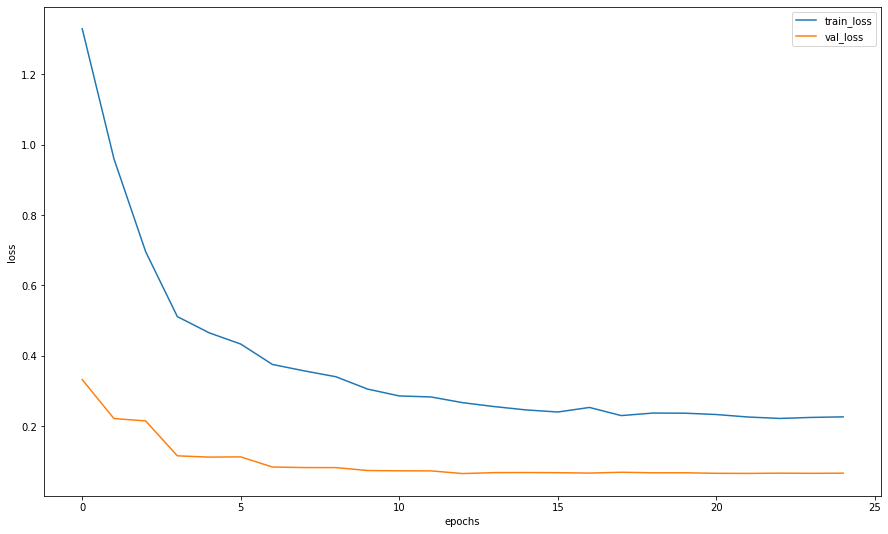

In [21]:
# Построим кривые обучения
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Последние 5-8 эпох явно лишние были. Результат должен соответствовать условиям задачи.

### Протестируем

In [22]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [23]:
random_characters = 666
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_B7, ex_img.unsqueeze(0))

In [24]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_B7, imgs)

In [26]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [27]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [28]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

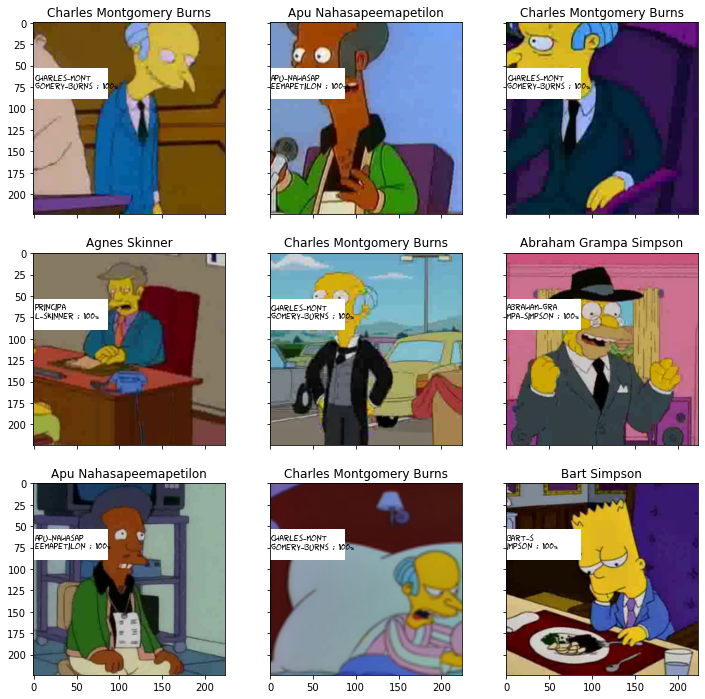

In [30]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_B7, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [31]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_B7, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [32]:
# создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
# сохраняю файл на гуг-диск
df.to_csv('gdrive/My Drive/simpsons_B3.csv', index=False)

In [33]:
! ls 

 characters_illustration.png  'path_to\model_pre_efficientnetB7.pth'   testset
 gdrive			       sample_data			       train
 label_encoder.pkl	       sample_submission.csv


In [34]:
# Посмотрим на итоговое предсказание
import pandas as pd
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


### RESNet (первые попытки)

In [ ]:
from torchvision import models

model_resnet = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(6

In [ ]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(512,42))

In [ ]:
# переключаемся на графический проц, если работает CPU пропустить
model_resnet.to("cuda")

In [ ]:
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=5, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 3.459081506333996


epoch:  20%|██        | 1/5 [04:00<16:01, 240.31s/it]


Epoch 001 train_loss: 3.4591     val_loss 3.1254 train_acc 0.0962 val_acc 0.1074
loss 3.1246982210096643


epoch:  40%|████      | 2/5 [07:59<11:59, 239.94s/it]


Epoch 002 train_loss: 3.1247     val_loss 3.0932 train_acc 0.1025 val_acc 0.1074
loss 3.048345954420299


epoch:  60%|██████    | 3/5 [11:58<07:59, 239.57s/it]


Epoch 003 train_loss: 3.0483     val_loss 2.8663 train_acc 0.1169 val_acc 0.1699
loss 2.6852525943480643


epoch:  80%|████████  | 4/5 [15:54<03:58, 238.69s/it]


Epoch 004 train_loss: 2.6853     val_loss 2.2750 train_acc 0.2344 val_acc 0.3439
loss 2.2129868521144243


epoch: 100%|██████████| 5/5 [19:51<00:00, 238.40s/it]


Epoch 005 train_loss: 2.2130     val_loss 2.0561 train_acc 0.3685 val_acc 0.4371


In [ ]:
import copy

# сохраняем веса нейросети в model
model_pre_weights = copy.deepcopy(model_resnet.state_dict())
torch.save(model_pre_weights, "path_to\\model_pre_weights.pth")

In [ ]:
# Включаем слои
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [ ]:
# обучаем
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=25, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 2.225978283523702


epoch:   4%|▍         | 1/25 [03:53<1:33:14, 233.10s/it]


Epoch 001 train_loss: 2.2260     val_loss 1.7603 train_acc 0.3724 val_acc 0.5048
loss 1.6260558145079398


epoch:   8%|▊         | 2/25 [07:50<1:29:49, 234.33s/it]


Epoch 002 train_loss: 1.6261     val_loss 1.3349 train_acc 0.5505 val_acc 0.6276
loss 1.2803297735064931


epoch:  12%|█▏        | 3/25 [11:47<1:26:15, 235.25s/it]


Epoch 003 train_loss: 1.2803     val_loss 1.0371 train_acc 0.6440 val_acc 0.7163
loss 0.9299071930258469


epoch:  16%|█▌        | 4/25 [15:45<1:22:37, 236.06s/it]


Epoch 004 train_loss: 0.9299     val_loss 0.7841 train_acc 0.7438 val_acc 0.7900
loss 0.7735936535008033


epoch:  20%|██        | 5/25 [19:44<1:18:58, 236.93s/it]


Epoch 005 train_loss: 0.7736     val_loss 0.6630 train_acc 0.7887 val_acc 0.8221
loss 0.684878922616564


epoch:  24%|██▍       | 6/25 [23:43<1:15:14, 237.59s/it]


Epoch 006 train_loss: 0.6849     val_loss 0.6751 train_acc 0.8099 val_acc 0.8233
loss 0.5265477393127892


epoch:  28%|██▊       | 7/25 [27:43<1:11:30, 238.35s/it]


Epoch 007 train_loss: 0.5265     val_loss 0.5408 train_acc 0.8563 val_acc 0.8596
loss 0.472094188755382


epoch:  32%|███▏      | 8/25 [31:44<1:07:43, 239.02s/it]


Epoch 008 train_loss: 0.4721     val_loss 0.5242 train_acc 0.8678 val_acc 0.8603
loss 0.4209219341060755


epoch:  36%|███▌      | 9/25 [35:44<1:03:47, 239.19s/it]


Epoch 009 train_loss: 0.4209     val_loss 0.5273 train_acc 0.8801 val_acc 0.8647
loss 0.34004372429233853


epoch:  40%|████      | 10/25 [39:43<59:50, 239.35s/it]


Epoch 010 train_loss: 0.3400     val_loss 0.4442 train_acc 0.9047 val_acc 0.8869
loss 0.3103293722957928


epoch:  44%|████▍     | 11/25 [43:44<55:56, 239.75s/it]


Epoch 011 train_loss: 0.3103     val_loss 0.4367 train_acc 0.9121 val_acc 0.8903
loss 0.2905680297005984


epoch:  48%|████▊     | 12/25 [47:44<51:57, 239.84s/it]


Epoch 012 train_loss: 0.2906     val_loss 0.4423 train_acc 0.9195 val_acc 0.8915
loss 0.24611634428630252


epoch:  52%|█████▏    | 13/25 [51:45<48:04, 240.34s/it]


Epoch 013 train_loss: 0.2461     val_loss 0.4286 train_acc 0.9318 val_acc 0.8970
loss 0.22298621294518906


epoch:  56%|█████▌    | 14/25 [55:48<44:09, 240.84s/it]


Epoch 014 train_loss: 0.2230     val_loss 0.4327 train_acc 0.9382 val_acc 0.8995
loss 0.21465965335575143


epoch:  60%|██████    | 15/25 [59:49<40:11, 241.15s/it]


Epoch 015 train_loss: 0.2147     val_loss 0.4214 train_acc 0.9425 val_acc 0.8993
loss 0.19258261398737794


epoch:  64%|██████▍   | 16/25 [1:03:35<35:28, 236.55s/it]


Epoch 016 train_loss: 0.1926     val_loss 0.4291 train_acc 0.9457 val_acc 0.9035
loss 0.18323667726332565


epoch:  68%|██████▊   | 17/25 [1:07:15<30:52, 231.61s/it]


Epoch 017 train_loss: 0.1832     val_loss 0.4172 train_acc 0.9495 val_acc 0.9062
loss 0.17744594907559527


epoch:  72%|███████▏  | 18/25 [1:10:54<26:34, 227.72s/it]


Epoch 018 train_loss: 0.1774     val_loss 0.4202 train_acc 0.9511 val_acc 0.9062
loss 0.16925730703056263


epoch:  76%|███████▌  | 19/25 [1:14:32<22:28, 224.79s/it]


Epoch 019 train_loss: 0.1693     val_loss 0.4134 train_acc 0.9544 val_acc 0.9085
loss 0.16063667332572182


epoch:  80%|████████  | 20/25 [1:18:11<18:35, 223.06s/it]


Epoch 020 train_loss: 0.1606     val_loss 0.4206 train_acc 0.9561 val_acc 0.9070
loss 0.15919034778542615


epoch:  84%|████████▍ | 21/25 [1:21:52<14:49, 222.49s/it]


Epoch 021 train_loss: 0.1592     val_loss 0.4216 train_acc 0.9549 val_acc 0.9070
loss 0.15172313837106852


epoch:  88%|████████▊ | 22/25 [1:25:35<11:07, 222.63s/it]


Epoch 022 train_loss: 0.1517     val_loss 0.4237 train_acc 0.9580 val_acc 0.9089
loss 0.15566131875655395


epoch:  92%|█████████▏| 23/25 [1:29:18<07:25, 222.83s/it]


Epoch 023 train_loss: 0.1557     val_loss 0.4225 train_acc 0.9565 val_acc 0.9091
loss 0.1451607451385279


epoch:  96%|█████████▌| 24/25 [1:33:03<03:43, 223.37s/it]


Epoch 024 train_loss: 0.1452     val_loss 0.4278 train_acc 0.9589 val_acc 0.9085
loss 0.14156579115081025


epoch: 100%|██████████| 25/25 [1:36:47<00:00, 232.30s/it]


Epoch 025 train_loss: 0.1416     val_loss 0.4262 train_acc 0.9602 val_acc 0.9087


In [ ]:
# сохранить веса нашей нейросети model
model_weights_25_epoch = copy.deepcopy(model_resnet.state_dict())
torch.save(model_weights_25_epoch, "path_to\\model_weights_25_epoch.pth")

In [ ]:
# загружаем сохраненное состояние весов нейросети
model_resnet.load_state_dict(torch.load("path_to\\model_pre_weights.pth"))

<All keys matched successfully>

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

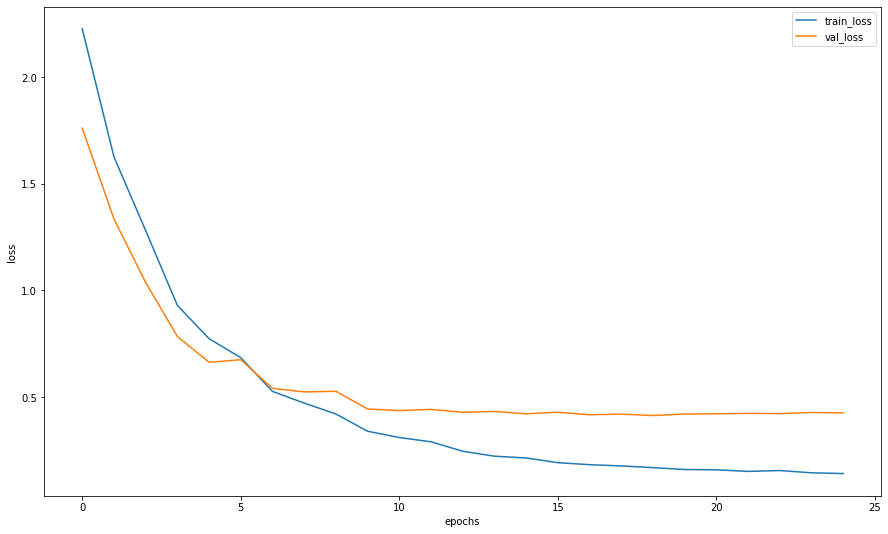

In [ ]:
# Построим кривые обучения
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()